<a href="https://colab.research.google.com/github/fachiny17/machine_learning/blob/main/tensorflow_course/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Transfer Learning with TensorFlow Part 2: Fine-tuning

## Create helper functions
In the previous notebooks, we've created a bunch of helper functions,
now we could rewrite them all,however, this is tedious.

So, we download and import it

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-08-28 10:21:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-08-28 10:21:27 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If you're running this notebook in Google Colab when it times out Colab will delete `helper_function.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time, we're goin to see how to use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2025-08-28 10:21:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.70.207, 74.125.24.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.70.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.9MB/s    in 8.5s    

2025-08-28 10:21:42 (18.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [5]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [6]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# Se an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.21040817e+02 5.60408173e+01 1.40408173e+01]
   [1.24622452e+02 6.06224480e+01 1.66224499e+01]
   [1.25076530e+02 5.87193871e+01 1.55051012e+01]
   ...
   [3.25612106e+01 1.80561142e+01 1.52091808e+01]
   [2.89591408e+01 1.77449074e+01 1.45306053e+01]
   [2.03673706e+01 1.05510387e+01 6.85206127e+00]]

  [[1.20811226e+02 5.87397957e+01 1.76887760e+01]
   [1.16632652e+02 5.36326523e+01 1.04948959e+01]
   [1.23658165e+02 5.98724518e+01 1.58724518e+01]
   ...
   [4.13213387e+01 2.44641953e+01 1.66784801e+01]
   [2.79641876e+01 1.38264828e+01 5.11217976e+00]
   [2.69949074e+01 1.34234695e+01 5.89796257e+00]]

  [[1.28724487e+02 6.99387741e+01 3.02142868e+01]
   [1.26739799e+02 6.54081650e+01 2.39948978e+01]
   [1.29234695e+02 6.66632690e+01 2.26632652e+01]
   ...
   [4.85000343e+01 2.87143211e+01 1.68571777e+01]
   [4.68672600e+01 2.85407543e+01 1.44947948e+01]
   [4.29438782e+01 2.60152969e+01 1.11581583e+01]]

  ...

  [[9.39387360e+01 3.91580734e+01 1.20151958e+01]
   [9

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like Resnet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregrate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs wit the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="10_percent_feature_extraction")])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape after base model: (None, 7, 7, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20250828-102151
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2813 - loss: 2.0855 - val_accuracy: 0.7516 - val_loss: 1.2547
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - accuracy: 0.7659 - loss: 1.1603 - val_accuracy: 0.8339 - val_loss: 0.8463
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8280 - loss: 0.7917 - val_accuracy: 0.8701 - val_loss: 0.6574
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8553 - loss: 0.6489 - val_accuracy: 0.8602 - val_loss: 0.6059
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8713 - loss: 0.5386 - val_accuracy: 0.8717 - val_loss: 0.5526


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 0.8705 - loss: 0.5419


[0.5473552942276001, 0.8695999979972839]

In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [13]:
# How about we get the summary of the base model
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
# How about a summary of our whole model
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

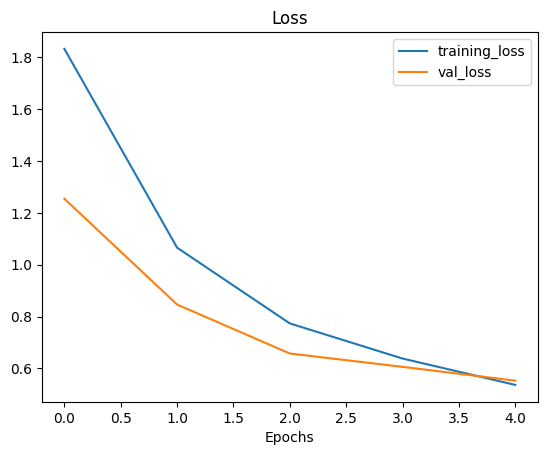

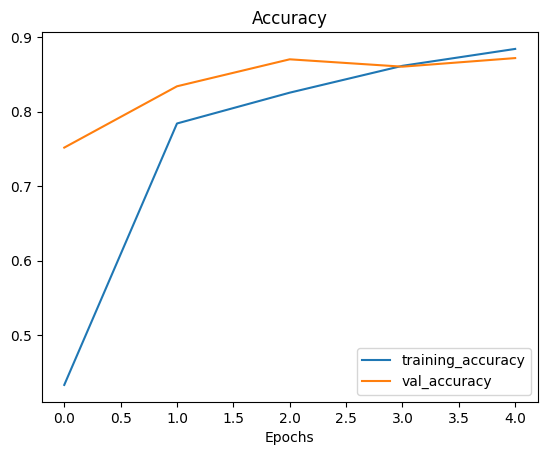

In [15]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

In [22]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of inout tensor: {input_tensor.shape}")
print(f"Shape of Gloval Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of inout tensor: (1, 4, 4, 3)
Shape of Gloval Average Pooled 2D tensor: (1, 3)


In [27]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [28]:
 # Using GlobalMaxPool2D

 global_max_pool = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
 print(f"Global MaxPooled tensor\n: {global_max_pool}\n")
 print(f"Shape of Global MaxPooled tensor:\n {global_max_pool.shape}\n")

 reduced_mean = tf.reduce_mean(input_tensor, axis=[1, 2])
 print(f"Reduced Mean Tensor:\n {reduced_mean}\n")
 print(f"Shape of Reducced Mean Rensor:\n {reduced_mean.shape}")

Global MaxPooled tensor
: [[0.9058464 1.1603122 1.6994323]]

Shape of Global MaxPooled tensor:
 (1, 3)

Reduced Mean Tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of Reducced Mean Rensor:
 (1, 3)


## Running a series of transfer learning experiments

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning with 10% of the training data with data augmentation.
4. `model_4`- use fine-tuning transfer-learning with 100% of the training data with data augmentation.

>**Note:** throughout the experiments, the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for `model_1`

In [30]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2025-08-28 12:06:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 172.217.194.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  20.1MB/s    in 7.9s    

2025-08-28 12:06:23 (16.2 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [39]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [40]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [42]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
